In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import os

japanize_matplotlib.japanize() 

In [3]:
e_data = pd.read_csv('./data/maikin/e.csv', encoding='utf_8_sig', low_memory=False)
e_data.head()

,年,月,産業分類,規模,就業形態,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,E,0,0,22630,18319.0,NaN,NaN,4311.0,207.0,182.0,25.0,24.2,NaN,NaN,NaN,NaN,NaN
1,1960,CY,E,4,0,28690,22409.0,NaN,NaN,NaN,200.3,173.8,26.5,24.2,NaN,NaN,NaN,NaN,NaN
2,1960,CY,E,5,0,20293,16501.0,NaN,NaN,NaN,207.9,184.9,23.0,24.1,NaN,NaN,NaN,NaN,NaN
3,1960,CY,E,7,0,16897,14742.0,NaN,NaN,NaN,215.3,190.2,25.1,24.3,NaN,NaN,NaN,NaN,NaN
4,1960,CY,E12,0,0,15370,13448.0,NaN,NaN,1922.0,208.5,186.6,21.9,23.9,NaN,NaN,NaN,NaN,NaN


In [5]:
all_data = pd.read_csv('./data/maikin/all_cleaned.csv', encoding='utf_8_sig', low_memory=False)
all_data.head()

,年,月,産業分類,規模,就業形態,現金給与総額,きまって支給する給与,所定内給与,所定外給与,特別給与,総実労働時間,所定内労働時間,所定外労働時間,出勤日数,前月末労働者数,増加労働者数,減少労働者数,本月末労働者数,パートタイム労働者数
0,1960,CY,C,0,0,26250,22547.0,NaN,NaN,3703.0,193.6,170.8,22.8,23.0,NaN,NaN,NaN,NaN,NaN
1,1960,CY,C,4,0,28786,24682.0,NaN,NaN,NaN,193.2,168.4,24.8,22.8,NaN,NaN,NaN,NaN,NaN
2,1960,CY,C,5,0,22422,19121.0,NaN,NaN,NaN,196.7,175.1,21.6,23.5,NaN,NaN,NaN,NaN,NaN
3,1960,CY,C,7,0,18826,16814.0,NaN,NaN,NaN,187.9,176.3,11.6,23.4,NaN,NaN,NaN,NaN,NaN
4,1960,CY,D,0,0,21213,17952.0,NaN,NaN,3261.0,211.0,186.4,24.6,24.1,NaN,NaN,NaN,NaN,NaN


## EDA

### 製造業の対他産業賃金比

In [19]:
all_wages = all_data[["年","月","産業分類", "規模", "就業形態", "現金給与総額"]]
all_wages.head()

,年,月,産業分類,規模,就業形態,現金給与総額
0,1960,CY,C,0,0,26250
1,1960,CY,C,4,0,28786
2,1960,CY,C,5,0,22422
3,1960,CY,C,7,0,18826
4,1960,CY,D,0,0,21213


In [20]:
# 月 = CY のみのデータを抽出
all_wages = all_wages[all_wages["月"] == "CY"]

In [21]:
# 産業分類が細かくなっているものを、統一（例：E12 => E）
all_wages["産業分類"] = all_wages["産業分類"].str.slice(0,1)
all_wages["産業分類"].unique()

array(['C', 'D', 'E', 'F', 'T', 'H', 'I', 'J', 'M', 'L', 'R', 'G', 'K',
       'O', 'P', 'Q', 'N'], dtype=object)

In [22]:
# 数値列を数値型に変換
all_wages["現金給与総額"] = pd.to_numeric(all_wages["現金給与総額"], errors='coerce')
all_wages["規模"] = pd.to_numeric(all_wages["規模"], errors='coerce')

# 規模ごとに分かれているデータを、平均して統一
all_wages = all_wages.groupby(["年", "月", "産業分類", "就業形態"]).mean(numeric_only=True).reset_index()
all_wages.head()

,年,月,産業分類,就業形態,規模,現金給与総額
0,1960,CY,C,0,4.0,24071.00
1,1960,CY,D,0,4.0,21433.25
2,1960,CY,E,0,4.0,22637.30
3,1960,CY,F,0,4.0,36734.00
4,1961,CY,C,0,4.0,26290.75


In [ ]:
# 就業形態が0（全形態）のみを抽出
all_wages = all_wages[all_wages["就業形態"] == 0]

# 不要な列をドロップ
all_wages = all_wages.drop(columns=["月","規模","就業形態"])

In [29]:
# その年の製造業に対する賃金比率を計算、小数点第3位まで
all_wages["製造業賃金比率"] = all_wages.apply(lambda row: round(row["現金給与総額"] / all_wages[(all_wages["年"] == row["年"]) & (all_wages["産業分類"] == "E")]["現金給与総額"].values[0], 3), axis=1)
all_wages.head()

,年,産業分類,現金給与総額,製造業賃金比率
0,1960,C,24071.00,1.063
1,1960,D,21433.25,0.947
2,1960,E,22637.30,1.000
3,1960,F,36734.00,1.623
4,1961,C,26290.75,1.059


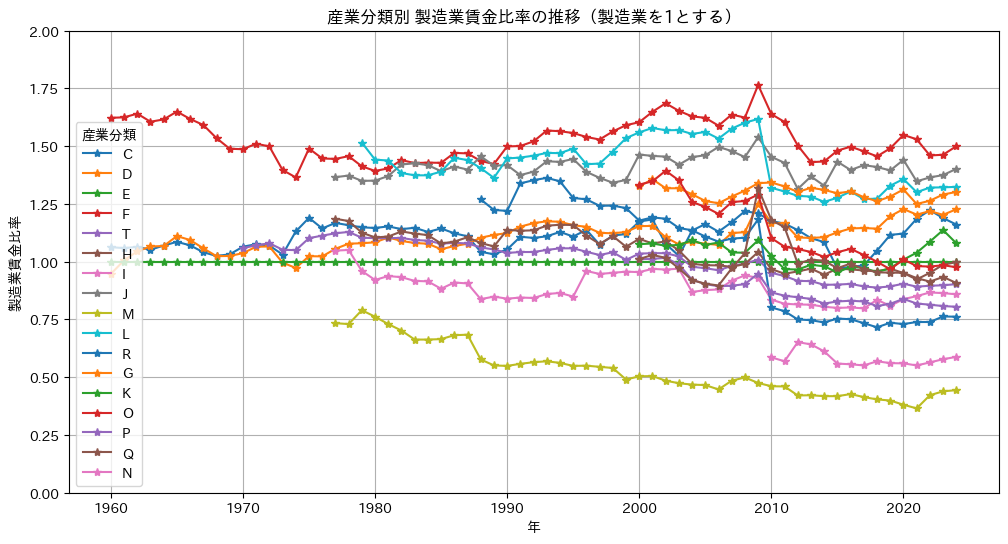

In [40]:
# 各産業別に線を分けて、折れ線グラフでプロット
plt.figure(figsize=(12, 6))

for industry in all_wages["産業分類"].unique():
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

- 以下の区別に分類する
    - 常に下回るもの
    - 交差するもの
    - 常に上回るもの

In [44]:
cat_lower = ["M","N"]
cat_upper = ["F","L","J","G"]
cat_cross = all_wages["産業分類"].unique()

# cat_crossから、cat_lowerとcat_upperに含まれる項目を削除
cat_cross = [item for item in cat_cross if item not in cat_lower and item not in cat_upper]
cat_cross

['C', 'D', 'E', 'T', 'H', 'I', 'R', 'K', 'O', 'P', 'Q']

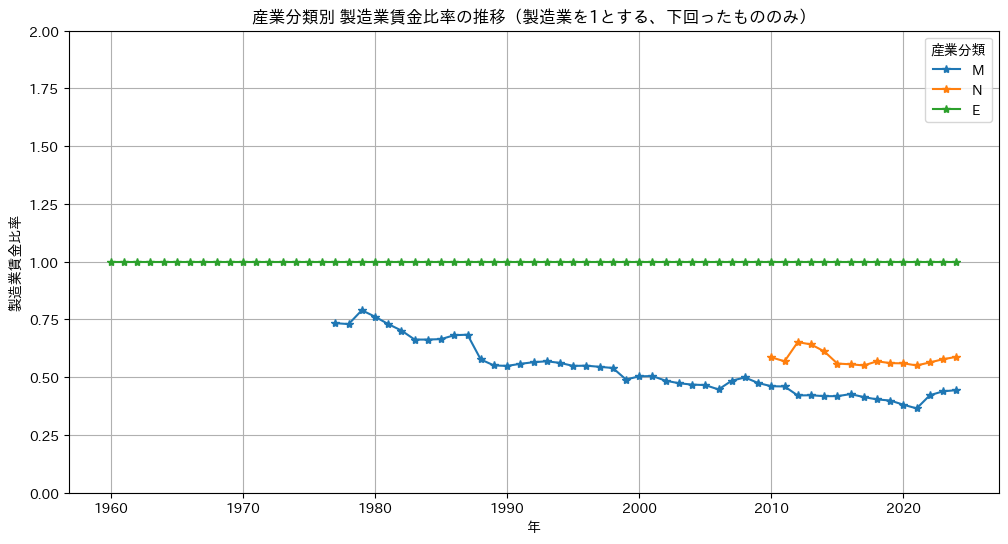

In [42]:
plt.figure(figsize=(12, 6))

cat_lower.append("E")

for industry in cat_lower:
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()

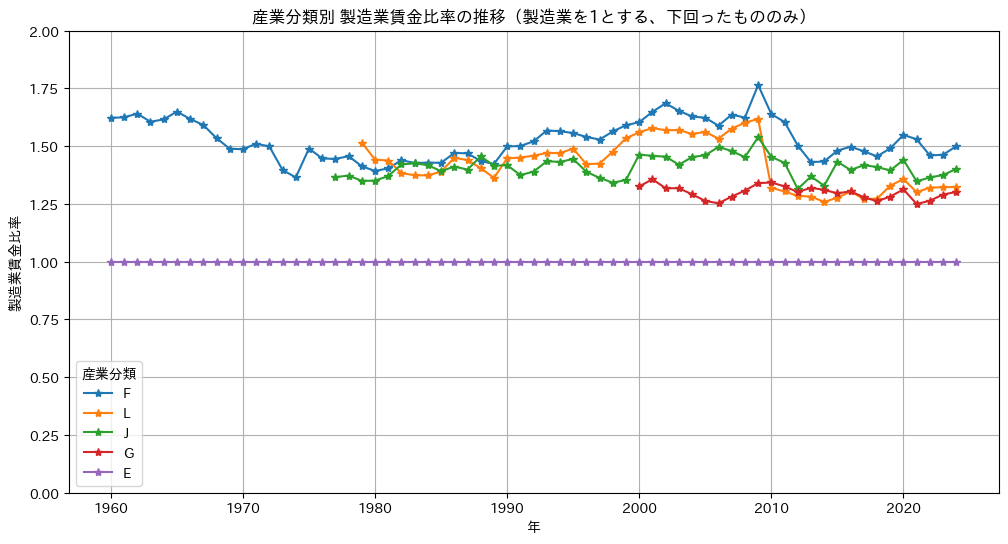

In [45]:
plt.figure(figsize=(12, 6))

cat_upper.append("E")

for industry in cat_upper:
    industry_data = all_wages[all_wages["産業分類"] == industry]
    plt.plot(industry_data["年"], industry_data["製造業賃金比率"], marker='*', label=industry)

plt.xlabel("年")
plt.ylabel("製造業賃金比率")
plt.ylim(0.0, 2.0)
plt.title("産業分類別 製造業賃金比率の推移（製造業を1とする、下回ったもののみ）")
plt.legend(title="産業分類")
plt.grid(True)
plt.show()